In [1]:
import imageio
import numpy as np
from functions import *
from PIL import Image

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
% matplotlib inline

In [2]:
# Read Some Images
X, Y, Joints, Hand_Info = read_img_data(10)

000_1001
000_1007
000_101
000_1013
000_1019
negative_images/0.jpg
negative_images/1.jpg
negative_images/10.jpg
negative_images/100.jpg
negative_images/1000.jpg


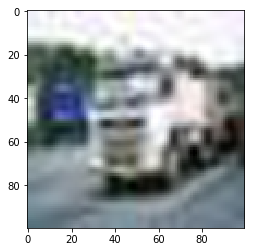

In [3]:
# Display an image
plt.imshow(X[9].astype(np.uint8))

In [5]:
# Print some Y's and J's. J = 0 means left hand, J = 1 means right hand.
# Y = 1 means hand is present in the image.
print(Y[:10])
print(Hand_Info[:10])

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [15]:
X[4].shape

(100, 100, 3)

In [9]:
labels = gen_labels(Y, Joints)

In [32]:
np.argwhere(labels[4] == 1)


array([[1, 1, 0]])

In [41]:
_, cx, cy, h, w = labels[4][1][1]

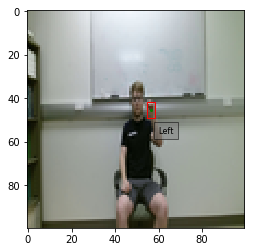

In [73]:
plot_bounding_box(X[4], cx, cy, w, h, Hand_Info[4])

In [159]:
print(X.shape)

X_rolled = to_channels_first(X)
X_rolled.shape

(10, 100, 100, 3)


(10, 3, 100, 100)

# PyTorch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit

In [7]:
dtype = torch.FloatTensor # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [24]:
X, Y, Joints, Hand_Info = read_img_data(100)

In [25]:
Y_train = gen_labels(Y, Joints, grid_size=1)
Y_rolled = np.rollaxis(Y_train, 3, 1)
print('Y_rolled shape: ', Y_rolled.shape)
X_rolled = to_channels_first(X)
# Y_rolled = to_channels_first(Y_train)
print('X_rolled shape: ', X_rolled.shape)
# print('Y_rolled shape: ', Y_rolled.shape)

Y_rolled shape:  (100, 5, 1, 1)
X_rolled shape:  (100, 3, 100, 100)


In [26]:
Y_train = torch.from_numpy(Y_rolled)
Y_train = Y_train.type(dtype)
X_train = torch.from_numpy(X_rolled).type(dtype)
print(X_train.size())
print(Y_train.size())

torch.Size([100, 3, 100, 100])
torch.Size([100, 5, 1, 1])


tensor([[[[ 0.0651]],

         [[ 0.1222]]],


        [[[ 0.0557]],

         [[ 0.1202]]],


        [[[ 0.0150]],

         [[ 0.1248]]],


        [[[ 0.0484]],

         [[ 0.0942]]],


        [[[ 0.0352]],

         [[ 0.0727]]],


        [[[ 0.0299]],

         [[ 0.0636]]],


        [[[ 0.0354]],

         [[ 0.0591]]],


        [[[ 0.0426]],

         [[ 0.0824]]],


        [[[ 0.0339]],

         [[ 0.0652]]],


        [[[ 0.0331]],

         [[ 0.0594]]],


        [[[ 0.0427]],

         [[ 0.0695]]],


        [[[ 0.0623]],

         [[ 0.1231]]],


        [[[ 0.0663]],

         [[ 0.1242]]],


        [[[ 0.0396]],

         [[ 0.1223]]],


        [[[ 0.0584]],

         [[ 0.1159]]],


        [[[ 0.0483]],

         [[ 0.0764]]],


        [[[ 0.0307]],

         [[ 0.0638]]],


        [[[ 0.0266]],

         [[ 0.0593]]],


        [[[ 0.0250]],

         [[ 0.0626]]],


        [[[ 0.0443]],

         [[ 0.0847]]],


        [[[ 0.0611]],

         [[ 0.124

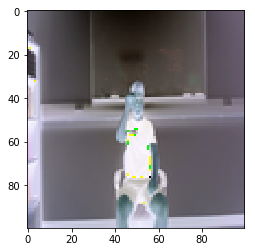

In [31]:
print(Y_train[:,3:])
plt.imshow(X[10])

In [385]:
def train(X, Y, model, loss_fn, optimizer, batch_size=10, num_epochs=1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
#         model.train()
        # X_batch, Y_batch = ...
        x_var = Variable(X.type(dtype))
        y_var = Variable(Y.type(dtype))

        scores = model(x_var)

        loss = loss_fn(scores, y_var)
#         if (t + 1) % print_every == 0:
#             print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('loss: ', loss)

In [33]:
fixed_model_base = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(16, 16, kernel_size=5, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 16, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 16, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    
        nn.Conv2d(16, 16, kernel_size=2, stride=1),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(16, 5, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
    )

fixed_model = fixed_model_base.type(dtype)

def conditional_loss():
#     return nn.MSELoss().type(dtype)
    def loss(Output, Y):
        N = Y.shape[0]
        grid_size = Y.shape[2]
        loss = 0.
        for out, y in (zip(Output, Y)):
            for i in range(grid_size):
                for j in range(grid_size):
                    if abs(y[0,i,j] - 1) < 0.01:
                        # loss = loss + nn.CrossEntropyLoss()((out[0,i,j],2), y[0,i,j])
                        loss = loss + ((out[:5,i,j] - y[:5,i,j])**2).sum()
                    else:
                        loss = loss + (out[0,i,j] - y[0,i,j])**2  # loss computed on only p_c
        return loss / N
    
    return loss

# loss_fn = conditional_loss()
loss_fn = nn.MSELoss().type(dtype)
optimizer = optim.Adam(fixed_model.parameters(), lr=1e-5)

## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

fixed_model.apply(init_weights)
# in your training loop:
it = 5
optimizer.zero_grad()   # zero the gradient buffers
fixed_model.train()
for iter in range(it):
    output = fixed_model(X_train)
    loss = loss_fn(output, Y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    # Does the update
    
    print('loss :' , loss.item())

loss : 0.2894338071346283
loss : 0.2872370779514313
loss : 0.2851420044898987
loss : 0.28311750292778015
loss : 0.28115859627723694


In [34]:
preds = fixed_model(X_train)

In [35]:
preds

tensor([[[[ 0.0000]],

         [[ 0.1228]],

         [[ 0.0003]],

         [[ 0.1730]],

         [[ 0.0651]]],


        [[[ 0.0000]],

         [[ 0.1049]],

         [[ 0.0000]],

         [[ 0.1696]],

         [[ 0.0793]]],


        [[[ 0.0000]],

         [[ 0.1120]],

         [[ 0.0036]],

         [[ 0.2004]],

         [[ 0.0401]]],


        [[[ 0.0000]],

         [[ 0.0833]],

         [[ 0.0002]],

         [[ 0.1422]],

         [[ 0.0920]]],


        [[[ 0.0000]],

         [[ 0.0785]],

         [[ 0.0225]],

         [[ 0.1805]],

         [[ 0.0421]]],


        [[[ 0.0000]],

         [[ 0.1067]],

         [[ 0.0133]],

         [[ 0.1482]],

         [[ 0.0715]]],


        [[[ 0.0000]],

         [[ 0.0298]],

         [[ 0.0000]],

         [[ 0.1231]],

         [[ 0.1750]]],


        [[[ 0.0000]],

         [[ 0.1523]],

         [[ 0.0000]],

         [[ 0.1227]],

         [[ 0.1002]]],


        [[[ 0.0000]],

         [[ 0.1415]],

         [[ 0.0000

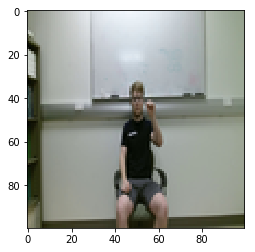

In [359]:
plt.imshow(X[4].astype('uint8'))

In [253]:
l = 0.
l = l + (output[0][:5,1,1] - Y_train[0][:5,1,1]).sum()**2
l

tensor(9.9404)

In [255]:
l = 0.
l = l + (output[0][0,1,1] - Y_train[0][0,1,1])**2
l

tensor(1.)

In [273]:
loss_fn = nn.MSELoss().type(dtype)
print(output[0][:][0][0])
print(Y_train[0][:][0][0])
print(Y_train[0][0])
print(Y_train[0][:5,1,1])
print(output[0][:5,1,1])
loss_fn(output[0][:5,1,1], Y_train[0][:5,1,1])

tensor([ 0.,  0.,  0.])
tensor([ 0.,  0.,  0.])
tensor([[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]])
tensor([ 1.0000,  0.5622,  0.4269,  0.1222,  0.0651])
tensor([ 0.,  0.,  0.,  0.,  0.])


tensor(0.3035)

In [242]:
(output[0][:5,1,1] - Y_train[0][:5,1,1])

tensor([-1.0000, -0.5622, -0.4269, -0.1222, -0.0651])

In [274]:
((output[0][:5,1,1] - Y_train[0][:5,1,1])**2).sum()

tensor(1.5175)

In [234]:
Y_train[0]

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5622,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.4269,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.1222,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0651,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

In [191]:
train(X_train, Y_train, fixed_model, loss_fn, optimizer, num_epochs=10)

Starting epoch 1 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 2 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 3 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 4 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 5 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 6 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 7 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 8 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 9 / 10
loss:  tensor(1.00000e-02 *
       2.8054)
Starting epoch 10 / 10
loss:  tensor(1.00000e-02 *
       2.8054)


In [178]:
print(fixed_model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU(inplace)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU(inplace)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 5, kernel_size=(2, 2), stride=(1, 1))
  (13): ReLU(inplace)
)


In [154]:
train(fixed_model, loss_fn, optimizer)

Starting epoch 1 / 1


RuntimeError: expected stride to be a single integer value or a list of 3 values to match the convolution dimensions, but got stride=[1, 1]

In [100]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)
z = y + 2

tensor([ -150.7955, -1412.2751,   698.5419])


In [102]:
gradients = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
z.backward(gradients)

print(x.grad)

tensor([  204.8000,  2048.0000,     0.2048])


In [103]:
x.grad

tensor([  204.8000,  2048.0000,     0.2048])

In [106]:
y.requires_grad

True

In [109]:
x = torch.randn(1, requires_grad=True)
y = x + 2
z = y * 3

z.backward()

In [111]:
x.grad

tensor([ 3.])